In [13]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

<h3>Importing important libraries</h3>

In [14]:
import pandas as pd
import os
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import mode
from sklearn.utils import resample

<h3>Creating a Boxplot</h3>

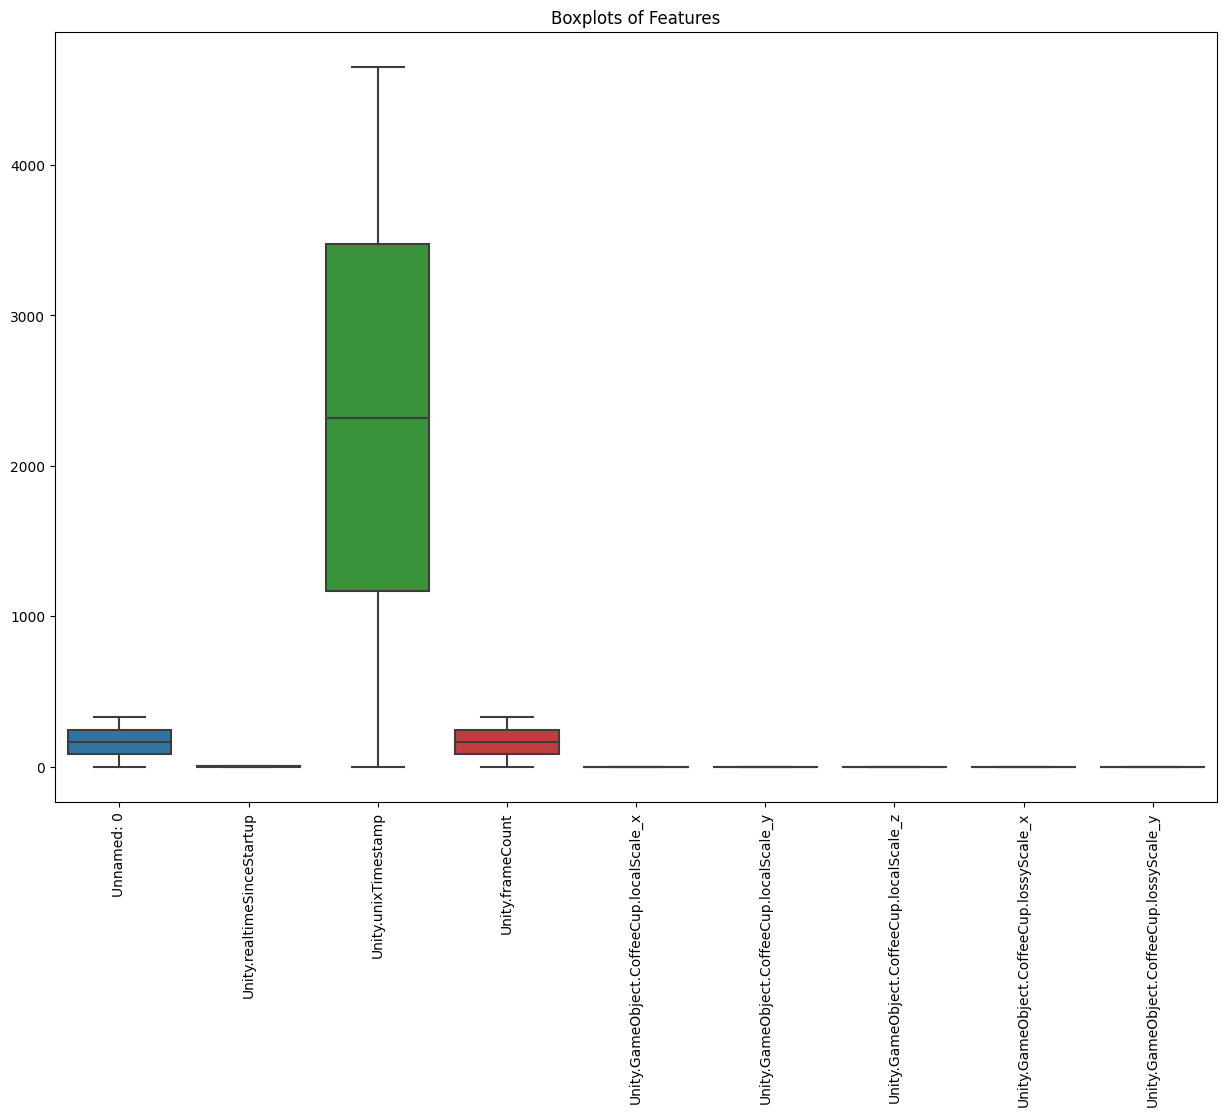

In [15]:
input_directory = '/public-datasets/liebers2022ijhci'
tsv_files = sorted(
    [f for f in os.listdir(input_directory) 
     if 'RescaleScene2H' in f and 'vr' in f and f.endswith('SESSION-1.tsv')]
)

input_file_path = os.path.join(input_directory, tsv_files[0])
data = pd.read_csv(input_file_path, sep='\t', low_memory=False)
descriptive_stats = data.describe()
#print(descriptive_stats)

plt.figure(figsize=(15, 10))
sns.boxplot(data=data[data.columns[0:10]])
plt.xticks(rotation=90)
plt.title('Boxplots of Features')
plt.show()

<h3>Creating a spatial plot for head position</h3>

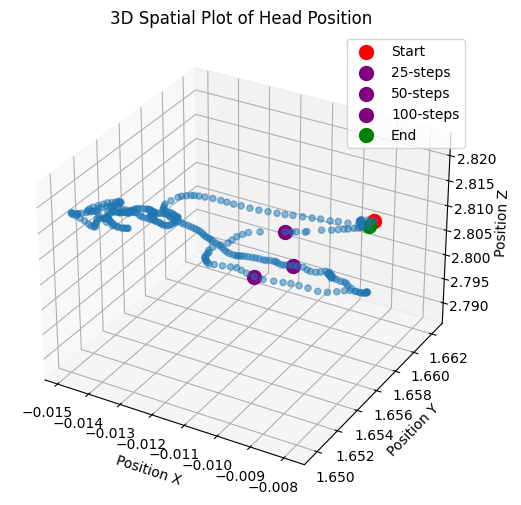

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['Unity.HeadPosition.position_x'], 
           data['Unity.HeadPosition.position_y'], 
           data['Unity.HeadPosition.position_z'], alpha=0.5)

ax.scatter(data['Unity.HeadPosition.position_x'].iloc[0], 
           data['Unity.HeadPosition.position_y'].iloc[0], 
           data['Unity.HeadPosition.position_z'].iloc[0], color='red', s=100, label='Start')
ax.scatter(data['Unity.HeadPosition.position_x'].iloc[25], 
           data['Unity.HeadPosition.position_y'].iloc[25], 
           data['Unity.HeadPosition.position_z'].iloc[25], color='purple', s=100, label='25-steps')
ax.scatter(data['Unity.HeadPosition.position_x'].iloc[50], 
           data['Unity.HeadPosition.position_y'].iloc[50], 
           data['Unity.HeadPosition.position_z'].iloc[50], color='purple', s=100, label='50-steps')
ax.scatter(data['Unity.HeadPosition.position_x'].iloc[100], 
           data['Unity.HeadPosition.position_y'].iloc[100], 
           data['Unity.HeadPosition.position_z'].iloc[100], color='purple', s=100, label='100-steps')
ax.scatter(data['Unity.HeadPosition.position_x'].iloc[-1], 
           data['Unity.HeadPosition.position_y'].iloc[-1], 
           data['Unity.HeadPosition.position_z'].iloc[-1], color='green', s=100, label='End')

ax.set_title('3D Spatial Plot of Head Position')
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_zlabel('Position Z')

ax.legend()

plt.show()

<h3>Defining the window slicing method</h3>

In [17]:
def window_slicing(data, window_size, step_size):
    slices = []
    num_windows = (len(data) - window_size) // step_size + 1
    for start in range(0, len(data) - window_size + 1, step_size):
        slices.append(data[start:start + window_size])
    return np.array(slices)

<h3>Function to find the smallest dataframe in a list of data</h3>

In [18]:
def find_min(data):
    min = 1000000
    for d in data:
        if d['Unity.frameCount'].count() < min:
            min = d['Unity.frameCount'].count()
    return min

<h3>Datenvorbereitung</h3>
<ul>
<li><strong>Dateien laden:</strong> Liest TSV-Dateien, die mit dem angegebenen Verhaltensnamen und Suffix übereinstimmen.</li>
<li><strong>Daten normalisieren:</strong> Normalisiert die Kopfpositionsdaten relativ zur Startposition.</li>
<li><strong>Feature-Auswahl:</strong> Filtert relevante Spalten, die Positionen und Rotationen enthalten.</li>
<li><strong>Daten bereinigen:</strong> Entfernt Zeilen mit fehlenden Werten.</li>
<li><strong>Skalieren:</strong>Skaliert die Features mit 'StandardScaler'.</li>
<li><strong>Fensterbildung:</strong> Teilt die Daten in überlappende Fenster für ein besseres Modelltraining.</li>
<li><strong>Trainings- und Validierungssplit:</strong> Teilt die Daten in Trainings- und Validierungssets.</li>
</ul>

In [19]:
def train_test_split_noShuffle(X_train_scaled_slices,y_train_sliced):
    np.random.seed(42)
    test_size = 0.2
    num_val_samples = int(test_size * len(X_train_scaled_slices))
    val_indices = np.random.choice(len(X_train_scaled_slices), num_val_samples, replace=False)
    val_mask = np.zeros(len(X_train_scaled_slices), dtype=bool)
    val_mask[val_indices] = True
    X_train_final = X_train_scaled_slices[~val_mask]
    y_train_final = y_train_sliced[~val_mask]
    X_val = X_train_scaled_slices[val_mask]
    y_val = y_train_sliced[val_mask]
    
    return X_train_final,X_val,y_train_final,y_val

In [20]:
def resample_df(df, target_length):
    current_length = len(df)
    resampled_df = df.reset_index(drop=True).interpolate(method='linear')
    resampled_df = resampled_df.reindex(np.linspace(0, current_length-1, target_length)).interpolate(method='linear').reset_index(drop=True)
    return resampled_df

In [21]:
def extract_pid(file_name):
    start_pos = file_name.find("PID-") + len("PID-")
    end_pos = file_name.find("_", start_pos)
    return int(file_name[start_pos:end_pos])

In [22]:
def prepare_train_data(behavior_name,file_suffix):
    # load Data
    input_directory = '/public-datasets/liebers2022ijhci'
    tsv_files = sorted([f for f in os.listdir(input_directory) 
                 if behavior_name in f and 'vr' in f and f.endswith(file_suffix)])

    #tsv_files = sorted(tsv_files, key=extract_pid)
    
    X_train_list = []
    y_train = []

    # Verarbeite jede Datei, um Trainingsdaten und Labels zu extrahieren
    for file_name in tsv_files:
        pid_match = re.search(r'PID-(\d+)', file_name)
        pid_number = pid_match.group(1) if pid_match else None
        
        if pid_number:
            
            y_train.append(int(pid_number))
        
            input_file_path = os.path.join(input_directory, file_name)
        
            data = pd.read_csv(input_file_path, sep='\t', low_memory=False)

            # Normalisiere die Kopfpositionen relativ zum Startpunkt
            data['Unity.HeadPosition.position_x'] -= data['Unity.HeadPosition.position_x'].iloc[0]
            data['Unity.HeadPosition.position_y'] -= data['Unity.HeadPosition.position_y'].iloc[0]
            data['Unity.HeadPosition.position_z'] -= data['Unity.HeadPosition.position_z'].iloc[0]
            # Wandle die Positionen in absolute Werte um
            data['Unity.HeadPosition.position_x'] = data['Unity.HeadPosition.position_x'].abs()
            data['Unity.HeadPosition.position_y'] = data['Unity.HeadPosition.position_y'].abs()
            data['Unity.HeadPosition.position_z'] = data['Unity.HeadPosition.position_z'].abs()
            
            
            # Filtere relevante Spalten
            filtered_columns = [
                col for col in data.columns 
                if (('position' in col.lower() or 'rotation' in col.lower()) and 
                    'metacarpal' not in col.lower() and
                    'gameobject' not in col.lower() and
                    'quaternion' not in col.lower())
            ]
        
            filtered_data = data[filtered_columns]
            X_train_list.append(filtered_data)

    # Kombiniere alle DataFrames in X_train_list zu einem einzigen DataFrame
    X_train = pd.concat(X_train_list, ignore_index=True)
    
    # Erweitere die Zielvariablen entsprechend der Größe der Datenabschnitte
    y_train_expanded = pd.Series(y_train).repeat([len(df) for df in X_train_list]).reset_index(drop=True)
    # Kombiniere die Eingabedaten und die Zielvariablen in einem DataFrame
    combined_df = X_train.copy()
    combined_df['PID'] = y_train_expanded

    # Entferne Zeilen mit fehlenden Werten
    combined_df = combined_df.dropna()

    # Trenne Eingabedaten und Zielvariablen
    X_train_clean = combined_df.drop(columns=['PID'])
    y_train_clean = combined_df['PID']

    # One-Hot-Encoding der Zielvariablen
    y_train_encoded = pd.get_dummies(y_train_clean, prefix='PID')

    # Skaliere die Eingabedaten
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    
    window_size = 30
    step_size = 20

    # Teile die Zielvariablen in Fenster
    y_train_sliced = window_slicing(y_train_encoded.values, window_size, step_size)
    # Nimm in jedem window die am häufigsten vorkommende label
    y_train_sliced = mode(y_train_sliced, axis=1).mode[:, 0,:]

    # Teile die skalierten Eingabedaten in Fenster
    X_train_scaled_slices = window_slicing(X_train_scaled, window_size, step_size)

    # Teile die Daten in Trainings- und Validierungsdatensätze auf
    X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled_slices, y_train_sliced, test_size=0.2, random_state=42)

    # Konvertiere die Datentypen in float32
    X_train_final = X_train_final.astype('float32')
    X_val =X_val.astype('float32')
    y_train_final = y_train_final.astype('float32')
    y_val =y_val.astype('float32')
    print(X_train_final.dtype)

    print(f"X_train_final shape: {X_train_final.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_train_final shape: {y_train_final.shape}")
    print(f"y_val shape: {y_val.shape}")

    return X_train_final, X_val, y_train_final, y_val, scaler


In [23]:
def prepare_test_data(behavior_name,file_suffix, scaler):
    input_directory = '/public-datasets/liebers2022ijhci'
    tsv_files = sorted([f for f in os.listdir(input_directory) 
                if behavior_name in f and 'vr' in f and f.endswith(file_suffix)])
    
    #tsv_files = sorted(tsv_files, key=extract_pid)
    
    X_test_list = []
    y_test = []

    for file_name in tsv_files:
        pid_match = re.search(r'PID-(\d+)', file_name)
        pid_number = pid_match.group(1) if pid_match else None
        
        if pid_number:
            
            y_test.append(int(pid_number))
            
            input_file_path = os.path.join(input_directory, file_name)
        
            data = pd.read_csv(input_file_path, sep='\t', low_memory=False)
        
            data['Unity.HeadPosition.position_x'] -= data['Unity.HeadPosition.position_x'].iloc[0]
            data['Unity.HeadPosition.position_y'] -= data['Unity.HeadPosition.position_y'].iloc[0]
            data['Unity.HeadPosition.position_z'] -= data['Unity.HeadPosition.position_z'].iloc[0]

            data['Unity.HeadPosition.position_x'] = data['Unity.HeadPosition.position_x'].abs()
            data['Unity.HeadPosition.position_y'] = data['Unity.HeadPosition.position_y'].abs()
            data['Unity.HeadPosition.position_z'] = data['Unity.HeadPosition.position_z'].abs()
            
            # Filter columns
            filtered_columns = [
                col for col in data.columns 
                if (('position' in col.lower() or 'rotation' in col.lower()) and 
                    'metacarpal' not in col.lower() and
                    'gameobject' not in col.lower() and
                    'quaternion' not in col.lower())
            ]
            
            filtered_data = data[filtered_columns]
            X_test_list.append(filtered_data)

    X_test = pd.concat(X_test_list, ignore_index=True)
    
    if behavior_name == 'ContextMenuScene2H':
        # Find indices of 0s and 2s
        zero_indices = [i for i, x in enumerate(y_test) if x == 0]
        seven_indices = [i for i, x in enumerate(y_test) if x == 7]
        
        # Swap the values at these indices
        for i in range(len(zero_indices)):
            y_test[zero_indices[i]] = 7
        for i in range(len(seven_indices)):
            y_test[seven_indices[i]] = 0

    y_test_expanded = pd.Series(y_test).repeat([len(df) for df in X_test_list]).reset_index(drop=True)

    combined_df = X_test.copy()
    combined_df['PID'] = y_test_expanded
    combined_df = combined_df.dropna()
   
    X_test_clean = combined_df.drop(columns=['PID'])
    y_test_clean = combined_df['PID']

    y_test_encoded = pd.get_dummies(y_test_clean, prefix='PID')
    
    X_test_scaled = scaler.transform(X_test_clean)
    
    window_size = 30
    step_size = 20
    
    X_test_scaled_slices = window_slicing(X_test_scaled, window_size, step_size)
    y_test_sliced = window_slicing(y_test_encoded.values, window_size, step_size)
    
    y_test_sliced = mode(y_test_sliced, axis=1).mode[:, 0,:]
    
    X_test_final = X_test_scaled_slices.astype('float32')
    y_test_final = y_test_sliced.astype('float32')

    print(f"X_test_final shape: {X_test_final.shape}")
    print(f"y_test_final shape: {y_test_final.shape}")
    

    return X_test_final, y_test_final

In [24]:
###
reposition_X_train, reposition_X_val,reposition_y_train, reposition_y_val, reposition_scaler = prepare_train_data('RepositionScene2H', 'SESSION-1.tsv')
print('-' *20)
contextmenu_X_train, contextmenu_X_val,contextmenu_y_train, contextmenu_y_val, contextmenu_scaler = prepare_train_data('ContextMenuScene2H', 'SESSION-1.tsv')
print('-' *20)
bikeyboard_X_train, bikeyboard_X_val,bikeyboard_y_train, bikeyboard_y_val, bikeyboard_scaler = prepare_train_data('KeyboardScene2H', 'SESSION-1.tsv')
print('-' *20)
rescale_X_train, rescale_X_val,rescale_y_train, rescale_y_val, rescale_scaler = prepare_train_data('RescaleScene2H', 'SESSION-1.tsv')

float32
X_train_final shape: (4000, 30, 258)
X_val shape: (1001, 30, 258)
y_train_final shape: (4000, 16)
y_val shape: (1001, 16)
--------------------
float32
X_train_final shape: (2299, 30, 258)
X_val shape: (575, 30, 258)
y_train_final shape: (2299, 16)
y_val shape: (575, 16)
--------------------
float32
X_train_final shape: (10819, 30, 258)
X_val shape: (2705, 30, 258)
y_train_final shape: (10819, 16)
y_val shape: (2705, 16)
--------------------
float32
X_train_final shape: (3230, 30, 258)
X_val shape: (808, 30, 258)
y_train_final shape: (3230, 16)
y_val shape: (808, 16)


In [25]:
###
reposition_X_test, reposition_y_test = prepare_test_data('RepositionScene2H', 'SESSION-2.tsv', reposition_scaler)
print('-' *20)
contextmenu_X_test, contextmenu_y_test = prepare_test_data('ContextMenuScene2H', 'SESSION-2.tsv', contextmenu_scaler)
print('-' *20)
bikeyboard_X_test, bikeyboard_y_test = prepare_test_data('KeyboardScene2H', 'SESSION-2.tsv', bikeyboard_scaler)
print('-' *20)
rescale_X_test, rescale_y_test = prepare_test_data('RescaleScene2H', 'SESSION-2.tsv', rescale_scaler)

X_test_final shape: (3538, 30, 258)
y_test_final shape: (3538, 16)
--------------------
X_test_final shape: (2838, 30, 258)
y_test_final shape: (2838, 16)
--------------------
X_test_final shape: (10588, 30, 258)
y_test_final shape: (10588, 16)
--------------------
X_test_final shape: (3203, 30, 258)
y_test_final shape: (3203, 16)


In [514]:
def check_for_nan(X_train,X_val,X_test):
    print('Check nan values in train and test data')
    print(np.isnan(X_train).sum())
    print(np.isnan(X_val).sum())
    print(np.isnan(X_test).sum())
    
    print('Check inf values in train and test data')
    print(np.isinf(X_train).sum())
    print(np.isinf(X_val).sum())
    print(np.isinf(X_test).sum())

In [515]:
check_for_nan(reposition_X_train,reposition_X_val,reposition_X_test)
check_for_nan(contextmenu_X_train,contextmenu_X_val,contextmenu_X_test)
check_for_nan(bikeyboard_X_train,bikeyboard_X_val,bikeyboard_X_test)
check_for_nan(rescale_X_train,rescale_X_val,rescale_X_test)

Check nan values in train and test data
0
0
0
Check inf values in train and test data
0
0
0
Check nan values in train and test data
0
0
0
Check inf values in train and test data
0
0
0
Check nan values in train and test data
0
0
0
Check inf values in train and test data
0
0
0
Check nan values in train and test data
0
0
0
Check inf values in train and test data
0
0
0


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, BatchNormalization,Bidirectional,Layer,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import HeNormal
from sklearn.utils.class_weight import compute_class_weight

<h4>Das erste Model:</h4>
Input Layer <br>
2 Hidden Dense Layer<br>
Output Layer<br>

In [31]:
def create_model(input_shape, num_classes, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(64, input_shape=(input_shape), activation='relu', kernel_initializer=HeNormal()))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

<h4>Das zweite Model:</h4>
Input Layer <br>
2 Hidden Conv1D Layer<br>
1 Hidden LSTM Layer<br>
Output Layer<br>

In [32]:
def create_complex_model(input_shape, num_classes, learning_rate=0.0001):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        LSTM(50),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

<h4>Das dritte Model:</h4>
Input Layer <br>
2 Hidden LSTM Layer<br>
Output Layer<br>

In [33]:
def create_complex_model2(input_shape, num_classes, learning_rate=0.001):
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

<h4>Das endgültige Model</h4>
Input Layer  mit kernel regularizer<br>
2 Hidden Conv1D Layer mit kernel regularizer<br>
2 Hidden LSTM Layer  mit kernel regularizer<br>
2 Hidden Dense Layer  mit kernel regularizer<br>
Output Layer mit kernel regularizer<br>

In [34]:
def create_most_complex_model(input_shape, num_classes, learning_rate=0.0001):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        #Dropout(0.3),
        
        Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        #Dropout(0.3),
        
        Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        #Dropout(0.3),
        
        LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01)),
        #Dropout(0.3),
        
        LSTM(100, kernel_regularizer=l2(0.01)),
        #Dropout(0.3),
        
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        #Dropout(0.3),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        #Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [35]:
def prepare_model(X_train,y_train):
    input_shape = (X_train.shape[1],X_train.shape[2])
    num_classes = y_train.shape[1]
    model = create_most_complex_model(input_shape, num_classes)
    return model

In [52]:
reposition_model = prepare_model(reposition_X_train,reposition_y_train)
contextmenu_model = prepare_model(contextmenu_X_train,contextmenu_y_train)
bikeyboard_model = prepare_model(bikeyboard_X_train,bikeyboard_y_train)
rescale_model = prepare_model(rescale_X_train,rescale_y_train)

In [37]:
def fit_model(model, X_train, y_train,X_val,y_val,epochs=100):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=[reduce_lr],
        verbose=1
    )

    return model

In [28]:
counter_1 =0
counter_2 =0
counter_3 =0
counter_4 =0

In [29]:
counter_1 +=200
print('current_epochs',counter_1)
reposition_model = fit_model(reposition_model,reposition_X_train,reposition_y_train,reposition_X_val,reposition_y_val,200)

current_epochs 200
Epoch 1/200
125/125 [==============================] - 5s 19ms/step - loss: 12.9751 - accuracy: 0.4880 - val_loss: 13.6590 - val_accuracy: 0.0430
Epoch 2/200
125/125 [==============================] - 2s 15ms/step - loss: 11.3091 - accuracy: 0.7680 - val_loss: 12.7387 - val_accuracy: 0.0899
Epoch 3/200
125/125 [==============================] - 2s 15ms/step - loss: 10.3114 - accuracy: 0.8480 - val_loss: 11.3709 - val_accuracy: 0.3526
Epoch 4/200
125/125 [==============================] - 2s 15ms/step - loss: 9.4863 - accuracy: 0.8960 - val_loss: 9.8233 - val_accuracy: 0.7962
Epoch 5/200
125/125 [==============================] - 2s 15ms/step - loss: 8.7389 - accuracy: 0.9250 - val_loss: 8.6413 - val_accuracy: 0.8961
Epoch 6/200
125/125 [==============================] - 2s 15ms/step - loss: 8.0773 - accuracy: 0.9457 - val_loss: 7.8891 - val_accuracy: 0.9201
Epoch 7/200
125/125 [==============================] - 2s 15ms/step - loss: 7.4385 - accuracy: 0.9607 - val_los

In [60]:
counter_2 +=200
print('current_epochs',counter_2)
contextmenu_model = fit_model(contextmenu_model,contextmenu_X_train,contextmenu_y_train,contextmenu_X_val,contextmenu_y_val,200)

current_epochs 200
Epoch 1/200
72/72 [==============================] - 4s 18ms/step - loss: 13.3932 - accuracy: 0.3815 - val_loss: 13.8864 - val_accuracy: 0.0852
Epoch 2/200
72/72 [==============================] - 1s 17ms/step - loss: 11.9482 - accuracy: 0.7177 - val_loss: 13.4079 - val_accuracy: 0.1130
Epoch 3/200
72/72 [==============================] - 1s 17ms/step - loss: 11.1210 - accuracy: 0.8286 - val_loss: 12.7666 - val_accuracy: 0.1983
Epoch 4/200
72/72 [==============================] - 1s 17ms/step - loss: 10.4371 - accuracy: 0.9013 - val_loss: 11.9906 - val_accuracy: 0.3617
Epoch 5/200
72/72 [==============================] - 1s 17ms/step - loss: 9.8352 - accuracy: 0.9369 - val_loss: 11.0582 - val_accuracy: 0.6452
Epoch 6/200
72/72 [==============================] - 1s 17ms/step - loss: 9.2566 - accuracy: 0.9539 - val_loss: 10.0201 - val_accuracy: 0.8783
Epoch 7/200
72/72 [==============================] - 1s 17ms/step - loss: 8.7092 - accuracy: 0.9682 - val_loss: 9.0644 

In [35]:
counter_3 +=100
print('current_epochs',counter_3)
bikeyboard_model = fit_model(bikeyboard_model,bikeyboard_X_train,bikeyboard_y_train,bikeyboard_X_val,bikeyboard_y_val,100)

current_epochs 100
Epoch 1/100
339/339 [==============================] - 9s 18ms/step - loss: 11.5680 - accuracy: 0.7037 - val_loss: 11.1736 - val_accuracy: 0.7190
Epoch 2/100
339/339 [==============================] - 5s 16ms/step - loss: 8.8325 - accuracy: 0.9151 - val_loss: 7.8780 - val_accuracy: 0.9523
Epoch 3/100
339/339 [==============================] - 5s 16ms/step - loss: 7.0647 - accuracy: 0.9514 - val_loss: 6.3402 - val_accuracy: 0.9682
Epoch 4/100
339/339 [==============================] - 5s 16ms/step - loss: 5.7577 - accuracy: 0.9636 - val_loss: 5.1776 - val_accuracy: 0.9786
Epoch 5/100
339/339 [==============================] - 5s 16ms/step - loss: 4.7159 - accuracy: 0.9698 - val_loss: 4.2706 - val_accuracy: 0.9771
Epoch 6/100
339/339 [==============================] - 5s 16ms/step - loss: 3.8661 - accuracy: 0.9779 - val_loss: 3.5000 - val_accuracy: 0.9808
Epoch 7/100
339/339 [==============================] - 5s 16ms/step - loss: 3.1660 - accuracy: 0.9811 - val_loss: 2

In [46]:
counter_4 +=200
print('current_epochs',counter_4)
rescal_model = fit_model(rescale_model,rescale_X_train,rescale_y_train,rescale_X_val,rescale_y_val,200)

current_epochs 200
Epoch 1/200
101/101 [==============================] - 5s 22ms/step - loss: 13.1694 - accuracy: 0.4337 - val_loss: 13.7414 - val_accuracy: 0.1176
Epoch 2/200
101/101 [==============================] - 2s 16ms/step - loss: 11.5060 - accuracy: 0.7706 - val_loss: 12.9605 - val_accuracy: 0.2005
Epoch 3/200
101/101 [==============================] - 2s 17ms/step - loss: 10.5391 - accuracy: 0.8721 - val_loss: 11.8537 - val_accuracy: 0.4344
Epoch 4/200
101/101 [==============================] - 2s 17ms/step - loss: 9.7569 - accuracy: 0.9152 - val_loss: 10.5703 - val_accuracy: 0.7649
Epoch 5/200
101/101 [==============================] - 2s 16ms/step - loss: 9.0238 - accuracy: 0.9489 - val_loss: 9.2222 - val_accuracy: 0.9245
Epoch 6/200
101/101 [==============================] - 2s 16ms/step - loss: 8.3064 - accuracy: 0.9709 - val_loss: 8.1873 - val_accuracy: 0.9468
Epoch 7/200
101/101 [==============================] - 2s 16ms/step - loss: 7.6496 - accuracy: 0.9789 - val_lo

<h3>Modellevaluierung</h3>
Die Modelle werden mit den Validierungsdaten bewertet.<br>
 Folgende Metriken wurden hier erstellt:<br>
  - Genauigkeit (accuracy)<br>
  - Konfusionsmatrix (confusion matrix)<br>
  - Klassifikationsberichte (classification report)<br>

In [38]:
def eval_val(model, X_val, y_val):
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f'Validation loss: {val_loss}')
    print(f'Validation accuracy: {val_accuracy}')

    y_val_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true = y_val.argmax(axis=-1)
    
    print(classification_report(y_val_true, y_pred_classes))
    conf_matrix = confusion_matrix(y_val_true, y_pred_classes)
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix - VAlidation Data')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    

32/32 [==============================] - 0s 5ms/step - loss: 0.0581 - accuracy: 0.9960
Validation loss: 0.058080267161130905
Validation accuracy: 0.9960039854049683
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00        48
           3       0.98      1.00      0.99        57
           4       1.00      1.00      1.00        42
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00        46
           7       0.98      1.00      0.99        43
           8       1.00      0.98      0.99        48
           9       1.00      1.00      1.00       236
          10       1.00      1.00      1.00        46
          11       0.98      1.00      0.99        52
          12       1.00      1.00      1.00        34
          13       1.00      0.99      0.99        77
          14       0.98 

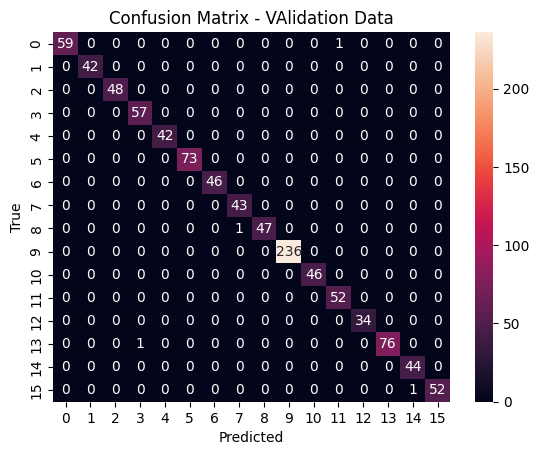

18/18 [==============================] - 0s 5ms/step - loss: 0.0818 - accuracy: 0.9896
Validation loss: 0.08182601630687714
Validation accuracy: 0.9895651936531067
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      1.00      1.00        52
           2       0.98      1.00      0.99        44
           3       1.00      1.00      1.00        35
           4       1.00      0.96      0.98        26
           5       1.00      1.00      1.00        37
           6       1.00      0.98      0.99        52
           7       0.97      0.97      0.97        34
           8       0.94      0.94      0.94        17
           9       1.00      0.97      0.99        40
          10       1.00      1.00      1.00        28
          11       1.00      1.00      1.00        61
          12       0.95      1.00      0.97        19
          13       1.00      0.97      0.98        29
          14       0.98  

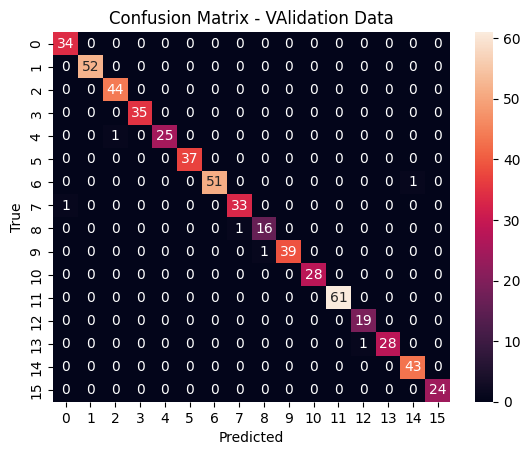

85/85 [==============================] - 0s 5ms/step - loss: 0.0427 - accuracy: 0.9978
Validation loss: 0.04273631423711777
Validation accuracy: 0.9977818727493286
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       0.99      1.00      0.99       223
           2       0.99      1.00      1.00       156
           3       1.00      1.00      1.00       223
           4       1.00      0.99      0.99       166
           5       1.00      1.00      1.00       145
           6       1.00      1.00      1.00        97
           7       1.00      1.00      1.00        96
           8       1.00      1.00      1.00       184
           9       0.99      0.98      0.99       187
          10       1.00      1.00      1.00       207
          11       1.00      1.00      1.00       156
          12       1.00      1.00      1.00       196
          13       1.00      1.00      1.00       148
          14       1.00  

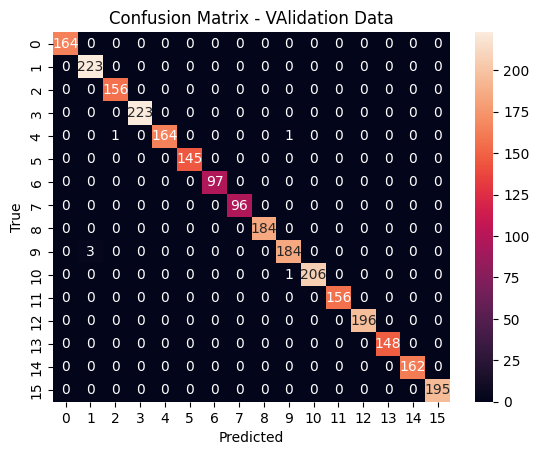

26/26 [==============================] - 0s 5ms/step - loss: 0.0557 - accuracy: 0.9950
Validation loss: 0.055711228400468826
Validation accuracy: 0.9950494766235352
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        53
           4       1.00      0.97      0.99        35
           5       1.00      0.98      0.99        53
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        48
           8       1.00      1.00      1.00        40
           9       0.99      1.00      0.99        98
          10       1.00      1.00      1.00        85
          11       0.96      1.00      0.98        48
          12       1.00      0.98      0.99        48
          13       1.00      0.98      0.99        44
          14       1.00 

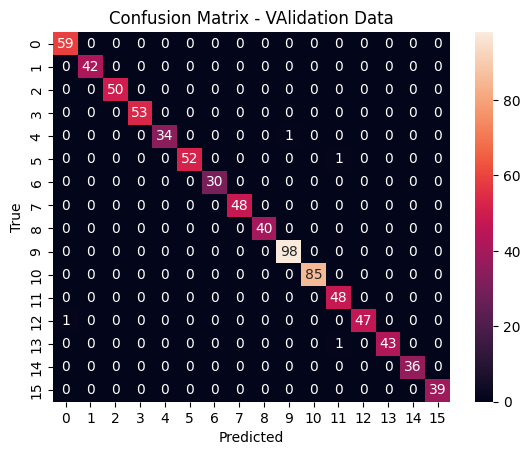

In [41]:
eval_val(reposition_model_79,reposition_X_val, reposition_y_val)
eval_val(contextmenu_model_85,contextmenu_X_val, contextmenu_y_val)
eval_val(bikeyboard_model_91,bikeyboard_X_val, bikeyboard_y_val)
eval_val(rescale_model_82,rescale_X_val, rescale_y_val)

<h3>Eine Majority Voting wird angewendet, um die Vorhersagen zu verbessern.</h3>

In [45]:
def majority_voting(predictions, window_size, step_size):

    # Anzahl der Fenster in den Vorhersagen
    num_windows = predictions.shape[0]
    interaction_predictions = []

    # Iteriere über die Fenster mit einem bestimmten Schritt
    for i in range(0, num_windows * step_size, step_size):
        window_start = i // step_size
        window_end =(i + window_size) // step_size
        # Stelle sicher, dass das Endfenster nicht über die Anzahl der Fenster hinausgeht
        if window_end > num_windows:
            window_end = num_windows
        # Sammle die Vorhersagen innerhalb des aktuellen Fensters
        window_preds = predictions[window_start:window_end]

        # Führe eine Mehrheitsabstimmung innerhalb des Fensters durch und füge das Ergebnis hinzu
        if len(window_preds) > 0:
            final_pred = mode(window_preds).mode[0]
            interaction_predictions.append(final_pred)
    return np.array(interaction_predictions)

In [49]:
def show_result(model,X_test,y_test,window_size, step_size):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test loss: {test_loss}')
    print(f'Test accuracy: {test_accuracy}')
    # Bestimmen der Vorhersagen.
    y_test_pred = model.predict(X_test)
    # Bestimmen der vorhergesagten Klassen.
    y_test_pred_classes = y_test_pred.argmax(axis=-1)
    # Klassen extrahieren
    y_test_true = y_test.argmax(axis=-1)
    
    final_test_predictions = majority_voting(y_test_pred_classes, window_size,step_size)
    
    print(classification_report(y_test_true, final_test_predictions, zero_division=0))
    conf_matrix = confusion_matrix(y_test_true, final_test_predictions)
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    # Konfusionsmatrix als Heatmap anzeigen
    plt.title('Confusion Matrix - Test Data (Majority Voting)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [50]:
# model_save_path = 'reposition_uid_model.h5'
# reposition_model.save(model_save_path)

# model_save_path = 'contextmenu_uid_model.h5'
# contextmenu_model.save(model_save_path)

# model_save_path = 'bikeyboard_uid_model.h5'
# bikeyboard_model.save(model_save_path)

# model_save_path = 'rescale_uid_model.h5'
# rescale_model.save(model_save_path)

111/111 [==============================] - 1s 5ms/step - loss: 1.6289 - accuracy: 0.6557
Test loss: 1.628856897354126
Test accuracy: 0.6557376980781555
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       273
           1       1.00      0.09      0.17       274
           2       0.76      0.94      0.84       188
           3       0.55      0.95      0.70       210
           4       0.82      0.94      0.88       192
           5       0.96      0.90      0.93       278
           6       0.92      0.94      0.93       200
           7       0.95      0.99      0.97       207
           8       0.37      0.53      0.44       144
           9       0.96      1.00      0.98       534
          10       0.00      0.00      0.00       143
          11       0.52      0.96      0.67       189
          12       0.86      0.95      0.91       150
          13       0.63      0.78      0.70       171
          14       0.93      0.77    

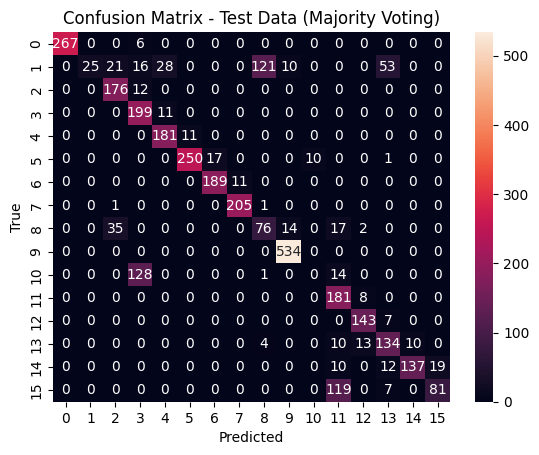

89/89 [==============================] - 1s 5ms/step - loss: 1.3089 - accuracy: 0.6575
Test loss: 1.3088728189468384
Test accuracy: 0.6575052738189697
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       197
           1       1.00      0.85      0.92       239
           2       0.65      0.93      0.77       191
           3       0.94      0.95      0.95       212
           4       0.98      0.80      0.88       188
           5       0.89      0.97      0.92       177
           6       1.00      0.67      0.81       166
           7       0.91      0.91      0.91       139
           8       0.82      0.86      0.84       154
           9       0.84      1.00      0.91       165
          10       0.95      0.84      0.89       194
          11       0.90      0.58      0.70       243
          12       0.93      0.93      0.93       225
          13       0.84      0.84      0.84        93
          14       0.77      0.87     

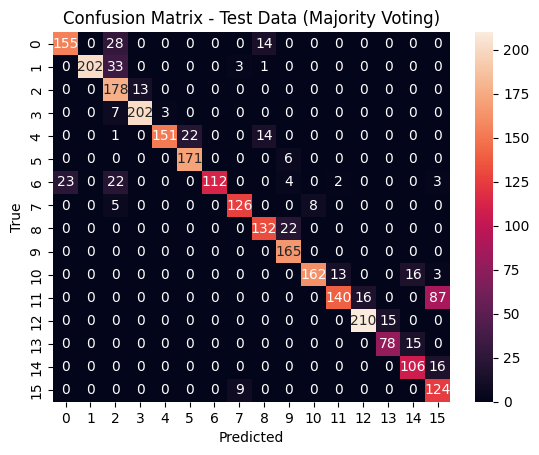

331/331 [==============================] - 2s 5ms/step - loss: 0.7158 - accuracy: 0.8459
Test loss: 0.7158451676368713
Test accuracy: 0.8458632230758667
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       539
           1       0.95      0.98      0.96       657
           2       0.96      0.98      0.97       828
           3       0.98      0.97      0.97       722
           4       0.97      0.98      0.98       524
           5       0.96      0.99      0.97       761
           6       0.99      0.96      0.98       628
           7       0.43      0.98      0.59       496
           8       0.98      0.93      0.95       776
           9       0.94      0.99      0.96       605
          10       0.98      0.16      0.27       770
          11       0.96      0.97      0.97       501
          12       1.00      0.94      0.97       732
          13       0.94      0.98      0.96       478
          14       0.99      0.91   

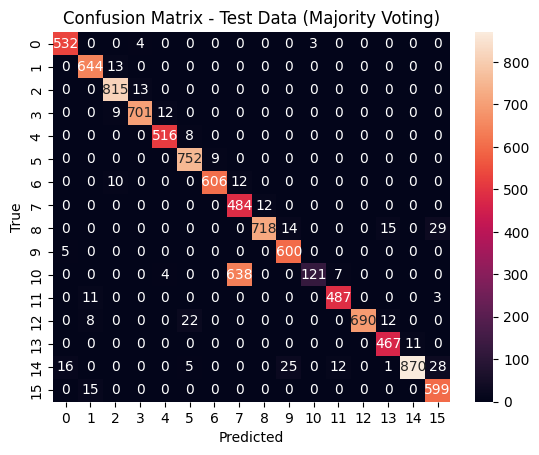

101/101 [==============================] - 1s 4ms/step - loss: 1.1899 - accuracy: 0.7284
Test loss: 1.1899018287658691
Test accuracy: 0.7283796668052673
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       154
           1       0.97      0.90      0.93       260
           2       0.89      0.97      0.93       210
           3       0.64      0.85      0.73       177
           4       0.94      0.21      0.35       207
           5       0.95      0.81      0.87       251
           6       0.00      0.00      0.00       137
           7       0.95      0.97      0.96       196
           8       0.97      0.95      0.96       212
           9       0.96      1.00      0.98       219
          10       0.88      0.58      0.70       207
          11       0.59      0.97      0.73       233
          12       0.84      0.97      0.90       216
          13       0.96      0.96      0.96       164
          14       0.96      0.87   

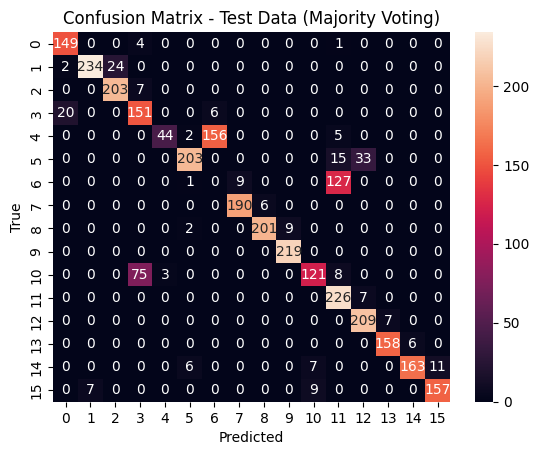

In [51]:
reposition_model_79= tf.keras.models.load_model('reposition_uid_model_79_230_10.h5')
contextmenu_model_85= tf.keras.models.load_model('contextmenu_uid_model_85_165_5.h5')
bikeyboard_model_91= tf.keras.models.load_model('bikeyboard_uid_model_91_250_10.h5')
rescale_model_82= tf.keras.models.load_model('rescale_uid_model_82_150_10.h5')
show_result(reposition_model_79, reposition_X_test, reposition_y_test,230,10)
show_result(contextmenu_model_85, contextmenu_X_test, contextmenu_y_test, 165,5)
show_result(bikeyboard_model_91, bikeyboard_X_test, bikeyboard_y_test, 250,10)
show_result(rescale_model_82, rescale_X_test, rescale_y_test, 150,10)

In [42]:
def show_result_without_MV(model,X_test,y_test):
    y_pred = model.predict(X_test)
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_true = y_test.argmax(axis=-1)
    
    test_loss, test_accuracy = model.evaluate(X_test,y_test)
    print(f'Test loss: {test_loss}')
    print(f'Test accuracy: {test_accuracy}')
    
    print(classification_report(y_test_true, y_pred_classes))
    conf_matrix = confusion_matrix(y_test_true, y_pred_classes)
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix - Test Data Without Majority Voting)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

111/111 [==============================] - 1s 5ms/step - loss: 1.6289 - accuracy: 0.6557
Test loss: 1.628856897354126
Test accuracy: 0.6557376980781555
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       273
           1       0.75      0.05      0.10       274
           2       0.63      0.55      0.59       188
           3       0.52      0.86      0.65       210
           4       0.77      0.71      0.74       192
           5       0.79      0.68      0.73       278
           6       0.79      0.91      0.85       200
           7       0.86      0.96      0.91       207
           8       0.24      0.31      0.27       144
           9       0.85      0.98      0.91       534
          10       0.06      0.03      0.04       143
          11       0.50      0.78      0.61       189
          12       0.50      0.73      0.59       150
          13       0.35      0.40      0.37       171
          14       0.64      0.52    

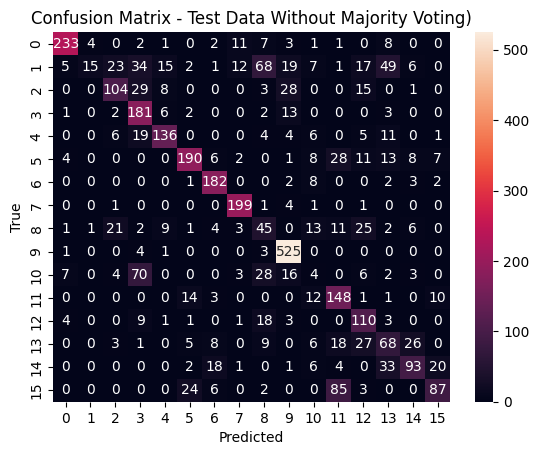

89/89 [==============================] - 0s 5ms/step - loss: 1.3089 - accuracy: 0.6575
Test loss: 1.3088728189468384
Test accuracy: 0.6575052738189697
              precision    recall  f1-score   support

           0       0.65      0.50      0.57       197
           1       0.86      0.48      0.61       239
           2       0.65      0.96      0.77       191
           3       0.82      0.58      0.68       212
           4       0.57      0.50      0.53       188
           5       0.98      0.92      0.95       177
           6       0.80      0.46      0.58       166
           7       0.41      0.60      0.49       139
           8       0.48      0.61      0.54       154
           9       0.72      0.94      0.82       165
          10       0.51      0.36      0.42       194
          11       0.81      0.54      0.65       243
          12       0.73      0.79      0.76       225
          13       0.76      0.83      0.79        93
          14       0.61      0.84     

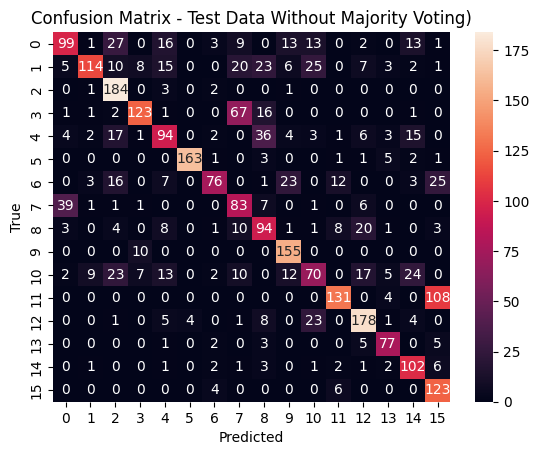

331/331 [==============================] - 2s 5ms/step - loss: 0.7158 - accuracy: 0.8459
Test loss: 0.7158451676368713
Test accuracy: 0.8458632230758667
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       539
           1       0.93      0.94      0.93       657
           2       0.90      0.93      0.92       828
           3       0.90      0.86      0.88       722
           4       0.91      0.96      0.93       524
           5       0.88      0.92      0.90       761
           6       0.95      0.90      0.93       628
           7       0.46      1.00      0.63       496
           8       0.95      0.90      0.92       776
           9       0.86      0.95      0.90       605
          10       0.69      0.15      0.25       770
          11       0.74      0.77      0.75       501
          12       0.97      0.90      0.93       732
          13       0.88      0.89      0.89       478
          14       0.96      0.80   

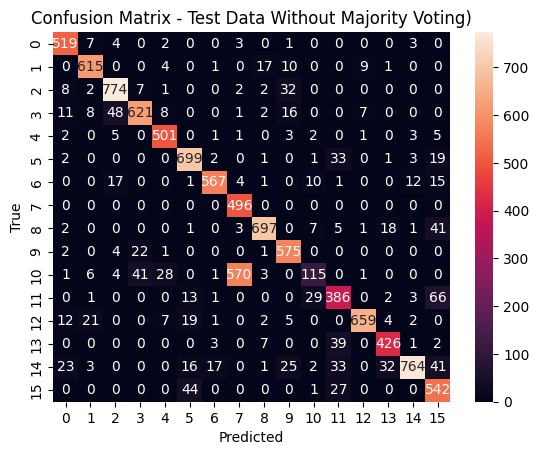

101/101 [==============================] - 0s 5ms/step - loss: 1.1899 - accuracy: 0.7284
Test loss: 1.1899018287658691
Test accuracy: 0.7283796668052673
              precision    recall  f1-score   support

           0       0.62      0.79      0.70       154
           1       0.93      0.70      0.80       260
           2       0.76      1.00      0.86       210
           3       0.56      0.69      0.62       177
           4       0.41      0.21      0.28       207
           5       0.67      0.60      0.64       251
           6       0.01      0.01      0.01       137
           7       0.93      0.96      0.95       196
           8       0.98      0.75      0.85       212
           9       0.93      0.96      0.94       219
          10       0.68      0.47      0.56       207
          11       0.57      0.89      0.69       233
          12       0.73      0.93      0.82       216
          13       0.89      0.90      0.89       164
          14       0.92      0.76   

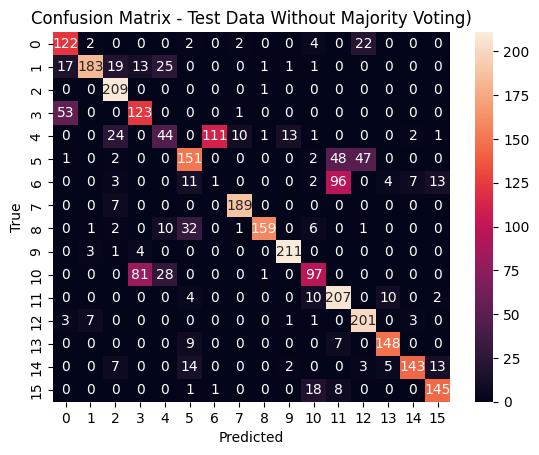

In [43]:
show_result_without_MV(reposition_model_79,reposition_X_test,reposition_y_test)
show_result_without_MV(contextmenu_model_85,contextmenu_X_test,contextmenu_y_test)
show_result_without_MV(bikeyboard_model_91,bikeyboard_X_test,bikeyboard_y_test)
show_result_without_MV(rescale_model_82,rescale_X_test,rescale_y_test)

In [196]:
model_save_path = 'reposition_uid_model.h5'
reposition_model.save(model_save_path)

In [197]:
model_save_path = 'contextmenu_uid_model.h5'
contextmenu_model.save(model_save_path)

In [198]:
model_save_path = 'bikeyboard_uid_model.h5'
bikeyboard_model.save(model_save_path)

In [199]:
model_save_path = 'rescale_uid_model.h5'
rescale_model.save(model_save_path)

In [200]:
exit()